# Prediction model for bank delinquencies on a loan

The dataset contains information about the clients of a certain bank.

The task is to predict the target variable according to various characteristics of clients - whether the client had a delay of 90 or more days or not (and if they did, the bank will not issue a loan to the client, otherwise it will).

### Description of the data

**Target variable**
- `SeriousDlqin2yrs`: a binary variable telling if the client was overdue by 90 days (1) or not (0).

**Features**
- `RevolvingUtilizationOfUnsecuredLines`: total balance on credit cards and personal lines of credit except real estate and no installment debt
like car loans divided by the sum of credit limits;
- `age`: age of the borrower;
- `NumberOfTime30-59DaysPastDueNotWorse`: how many times 30-59 days past due in the last 2 years;
- `DebtRatio`: monthly expenses (payment of debts, alimony, living expenses) divided by monthly income;
- `MonthlyIncome`: monthly income;
- `NumberOfOpenCreditLinesAndLoans`: number of open loans (e.g. car loan or mortgage) and credit cards;
- `NumberOfTimes90DaysLate`: number of times past due (90 days or more);
- `RealEstateLoansOrLines`: encoded number of loans (including secured by housing) - the larger the letter code, the more loans;
- `NumberOfTime60-89DaysPastDueNotWorse`: how many times in the last 2 years the borrower has delayed payment by 60-89 days;
- `NumberOfDependents`: number of dependents in care (spouses, children, etc.);
- `GroupAge`: coded age group - the larger the code, the greater the age.

## Importing libraries

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import pickle

from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, Normalizer
from sklearn.metrics import (classification_report,
accuracy_score,
precision_score,
recall_score,
f1_score,
roc_auc_score)
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [71]:
RANDOM_STATE = 11235

In [72]:
DATASET_PATH = "https://raw.githubusercontent.com/evgpat/stepik_from_idea_to_mvp/main/datasets/credit_scoring.csv"

## EDA

### Handling the data

Let's start with loading the data.

In [73]:
df = pd.read_csv(DATASET_PATH)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   135155 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfDependents                    146076 non-null  float64
 10  RealEstateLoansOrLines                150000 non-null  object 
 11  

I suggest to make columns' labels a bit fancier in a "PEP 8" style.

In [75]:
df = df.rename(columns={'SeriousDlqin2yrs' : 'dlq_90_days_plus',
                        'RevolvingUtilizationOfUnsecuredLines' : 'balance2credit_ratio',
                        'NumberOfTime30-59DaysPastDueNotWorse' : 'count_dlq_30-59_days',
                        'DebtRatio' : 'spending2income_ratio',
                        'MonthlyIncome' : 'monthly_income',
                        'NumberOfOpenCreditLinesAndLoans' : 'open_debt',
                        'NumberOfTimes90DaysLate' : 'count_dlq_90_days_plus',
                        'NumberOfTime60-89DaysPastDueNotWorse' : 'count_dlq_60-89_days',
                        'NumberOfDependents' : 'count_dependents',
                        'RealEstateLoansOrLines' : 'count_debt_coded',
                        'GroupAge' : 'group_age'})

All right, now let's have a look at the data itself.

In [76]:
df.head()

,dlq_90_days_plus,balance2credit_ratio,age,count_dlq_30-59_days,spending2income_ratio,monthly_income,open_debt,count_dlq_90_days_plus,count_dlq_60-89_days,count_dependents,count_debt_coded,group_age
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b
2,1,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0,A,c
3,0,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0,A,b
4,0,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0,A,d


Previously we've noticed that we have missing values in our data. Also the classes of our target variable might be imbalanced. Let's check both the balance of classes and missing values for each one.

In [77]:
df.isna().sum()

dlq_90_days_plus              0
balance2credit_ratio          0
age                       14845
count_dlq_30-59_days          0
spending2income_ratio         0
monthly_income            29731
open_debt                     0
count_dlq_90_days_plus        0
count_dlq_60-89_days          0
count_dependents           3924
count_debt_coded              0
group_age                     0
dtype: int64

In [78]:
print('Missing values for class 0:')
print(df.loc[df['dlq_90_days_plus'] == 0].isna().sum(), '\n')
print('Missing values for class 1:')
print(df.loc[df['dlq_90_days_plus'] == 1].isna().sum())

Missing values for class 0:
dlq_90_days_plus              0
balance2credit_ratio          0
age                       13845
count_dlq_30-59_days          0
spending2income_ratio         0
monthly_income            28062
open_debt                     0
count_dlq_90_days_plus        0
count_dlq_60-89_days          0
count_dependents           3745
count_debt_coded              0
group_age                     0
dtype: int64 

Missing values for class 1:
dlq_90_days_plus             0
balance2credit_ratio         0
age                       1000
count_dlq_30-59_days         0
spending2income_ratio        0
monthly_income            1669
open_debt                    0
count_dlq_90_days_plus       0
count_dlq_60-89_days         0
count_dependents           179
count_debt_coded             0
group_age                    0
dtype: int64


The omissions are quite proportional. Noted.

In [79]:
df['dlq_90_days_plus'].value_counts()

0    139974
1     10026
Name: dlq_90_days_plus, dtype: int64

And the classes are heavily imbalanced. We'll have to deal with later. For now let's continue with our explorations.

In [80]:
df.describe(include='all')

,dlq_90_days_plus,balance2credit_ratio,age,count_dlq_30-59_days,spending2income_ratio,monthly_income,open_debt,count_dlq_90_days_plus,count_dlq_60-89_days,count_dependents,count_debt_coded,group_age
count,150000.000000,150000.000000,135155.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,146076.000000,150000,150000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,d
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140048,47268
mean,0.066840,6.048438,52.293618,0.421033,353.005076,6.670221e+03,8.452760,0.265973,0.240387,0.757222,NaN,NaN
std,0.249746,249.755371,14.772577,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,4.155179,1.115086,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,0.000000,1.000000,NaN,NaN


We can definitely see the outliers in almost all of out numerical features. Especially drastic ones are in the `balance2credit_ratiot_ratio`, `spending2income_ratio` and `monthly_income`.

By the way, let's separate the features by their type.

In [81]:
categorical = ['count_debt_coded', 'group_age']
numeric = [i for i in df.columns if i not in categorical]

All right, now we are dealing with outliers. We shall remove everything outside 25th and 75th quantiles ± 1.5 times IQR.

In [82]:
def iqr_cleaner(data):
  for col in data.columns:
    first_q = data[col].quantile(0.25)
    third_q = data[col].quantile(0.75)
    iqr = third_q - first_q
    lower = first_q - 1.5 * iqr
    upper = third_q + 1.5 * iqr
    data.loc[((data[col] < lower) | (data[col] > upper)), col] = np.NaN
  return data

In [83]:
df.loc[:, ['balance2credit_ratio',
           'spending2income_ratio',
           'monthly_income']] = iqr_cleaner(df.loc[:, ['balance2credit_ratio',
                                                       'spending2income_ratio',
                                                       'monthly_income']])

In [84]:
df.isna().sum()

dlq_90_days_plus              0
balance2credit_ratio        763
age                       14845
count_dlq_30-59_days          0
spending2income_ratio     31311
monthly_income            34610
open_debt                     0
count_dlq_90_days_plus        0
count_dlq_60-89_days          0
count_dependents           3924
count_debt_coded              0
group_age                     0
dtype: int64

Now we have a bit more omissions. Let's deal with them.

* The number of omissions in `balance2credit_ratio`, `age` and `count_dependents` is relatively small, so we can choose to drop them;
* Dealing with `spending2income_ratio` and `monthly_income` is tougher. There are a lot of omissions in them. We can replace missed values with randomly selected values of these variables for each age group assuming the distribution within each group normal (we'll check that eventually).

In [85]:
df = df.dropna(subset=['balance2credit_ratio', 'age', 'count_dependents'])

In [86]:
df['group_age'].value_counts()

d    46029
c    41687
e    26515
b    16711
a        1
Name: group_age, dtype: int64

A strange group "a" looks like a technical issue. Probably we can remove it.

In [87]:
df.groupby('group_age')['age'].agg(['min', 'max'])

,min,max
group_age,,
a,0.0,0.0
b,21.0,34.0
c,35.0,49.0
d,50.0,64.0
e,65.0,107.0


In [88]:
df.groupby('group_age')['age'].median()

group_age
a     0.0
b    30.0
c    43.0
d    57.0
e    72.0
Name: age, dtype: float64

Yep, we definitely can remove it. And replace missing values with those medians.

In [89]:
df = df.loc[df['group_age'] != 'a']

Let's check how we are doing.

In [90]:
df.isna().sum()

dlq_90_days_plus              0
balance2credit_ratio          0
age                           0
count_dlq_30-59_days          0
spending2income_ratio     24992
monthly_income            27500
open_debt                     0
count_dlq_90_days_plus        0
count_dlq_60-89_days          0
count_dependents              0
count_debt_coded              0
group_age                     0
dtype: int64

Quite alright. Now let's deal with tougher ones. First, we are to check the distributions of those variables for each age group.

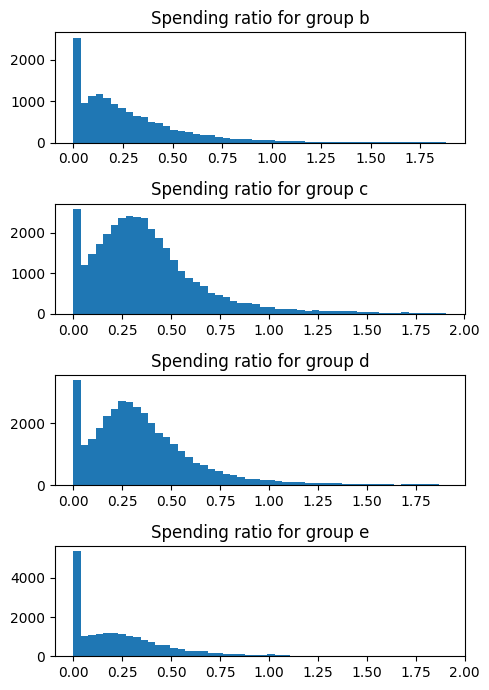

In [91]:
fig, ax = plt.subplots(4, 1, figsize=(5,7));
ax[0].hist(df.query('group_age == "b"')['spending2income_ratio'], bins=50);
ax[1].hist(df.query('group_age == "c"')['spending2income_ratio'], bins=50);
ax[2].hist(df.query('group_age == "d"')['spending2income_ratio'], bins=50);
ax[3].hist(df.query('group_age == "e"')['spending2income_ratio'], bins=50);

ax[0].set_title('Spending ratio for group b');
ax[1].set_title('Spending ratio for group c');
ax[2].set_title('Spending ratio for group d');
ax[3].set_title('Spending ratio for group e');
plt.tight_layout()

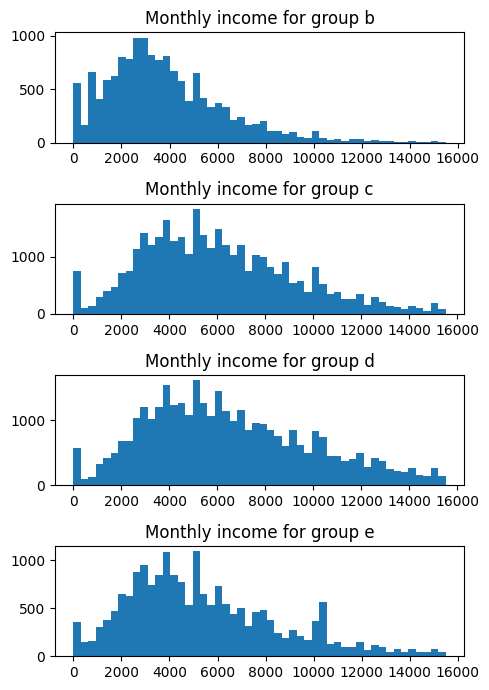

In [92]:
fig, ax = plt.subplots(4, 1, figsize=(5,7));
ax[0].hist(df.query('group_age == "b"')['monthly_income'], bins=50);
ax[1].hist(df.query('group_age == "c"')['monthly_income'], bins=50);
ax[2].hist(df.query('group_age == "d"')['monthly_income'], bins=50);
ax[3].hist(df.query('group_age == "e"')['monthly_income'], bins=50);

ax[0].set_title('Monthly income for group b');
ax[1].set_title('Monthly income for group c');
ax[2].set_title('Monthly income for group d');
ax[3].set_title('Monthly income for group e');
plt.tight_layout()

If a distribution for `monthly_income` looks roughly normal, looking at the plots we can see that it might be better to use a sample median for `spending2income_ratio` since its distribution can hardly be approximated with a normal one.

In [93]:
df['spending2income_ratio'] = df.groupby('group_age')['spending2income_ratio'].transform(lambda x: x.fillna(x.median()))

In [94]:
df['monthly_income'] = df.groupby('group_age')['monthly_income']\
.transform(lambda x: x.fillna(np.random.normal(loc=x.mean(), scale=x.std())))

In [95]:
df.isna().sum()

dlq_90_days_plus          0
balance2credit_ratio      0
age                       0
count_dlq_30-59_days      0
spending2income_ratio     0
monthly_income            0
open_debt                 0
count_dlq_90_days_plus    0
count_dlq_60-89_days      0
count_dependents          0
count_debt_coded          0
group_age                 0
dtype: int64

In [96]:
df.describe(include='all')

,dlq_90_days_plus,balance2credit_ratio,age,count_dlq_30-59_days,spending2income_ratio,monthly_income,open_debt,count_dlq_90_days_plus,count_dlq_60-89_days,count_dependents,count_debt_coded,group_age
count,130942.000000,130942.000000,130942.000000,130942.000000,130942.000000,130942.000000,130942.000000,130942.000000,130942.000000,130942.000000,130942,130942
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,4
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,d
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122135,46029
mean,0.066067,0.319089,52.132226,0.403805,0.323586,6813.392356,8.540331,0.244253,0.220426,0.757900,NaN,NaN
std,0.248401,0.349347,14.600692,3.972519,0.258880,3689.273904,5.147806,3.944465,3.930807,1.114038,NaN,NaN
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,0.030732,41.000000,0.000000,0.171962,3833.000000,5.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.156252,52.000000,0.000000,0.304645,6200.000000,8.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.000000,0.553673,62.000000,0.000000,0.409246,9946.764148,11.000000,0.000000,0.000000,1.000000,NaN,NaN


All right, the omissions are handled. Now we should have a look at some histograms and boxplots for our numerical data.

In [97]:
def hist_and_box(data, label):
  f, axes = plt.subplots(1, 2, figsize=(10, 4));
  axes[0].set_title(f'Histogram of {label} distribution');
  sns.histplot(data, bins=50, kde=True, ax=axes[0]);
  axes[1].set_title(f'Boxplot of {label} distribution');
  sns.boxplot(data, ax=axes[1]);
  plt.show();

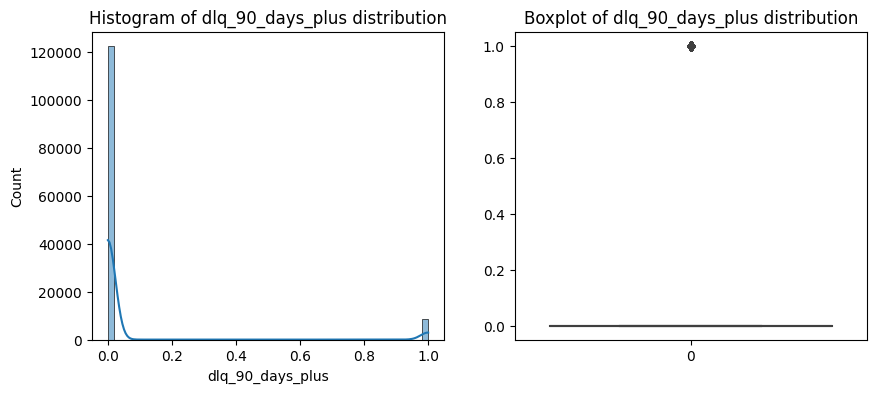

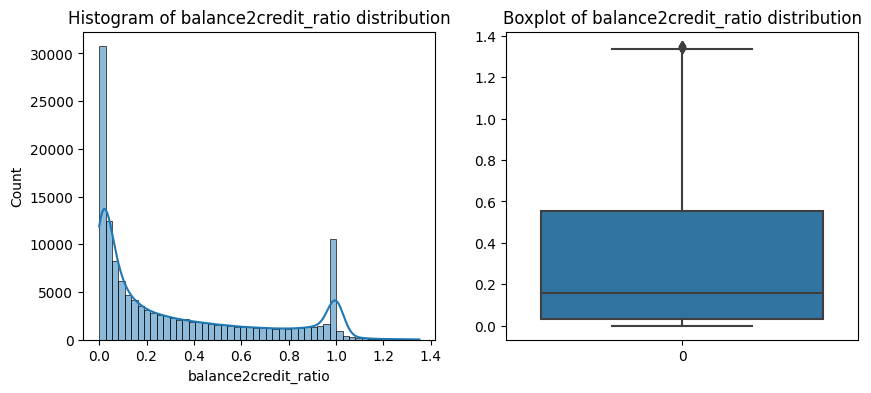

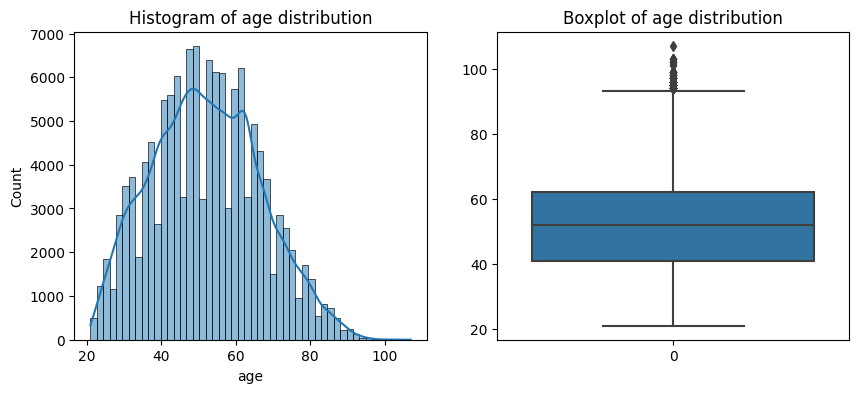

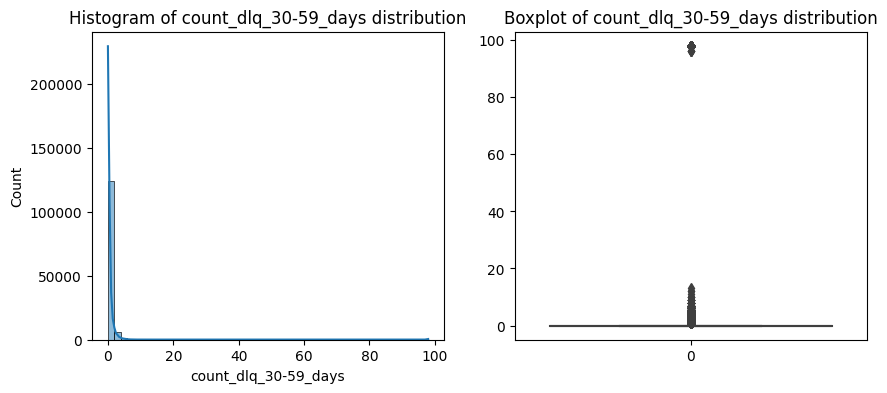

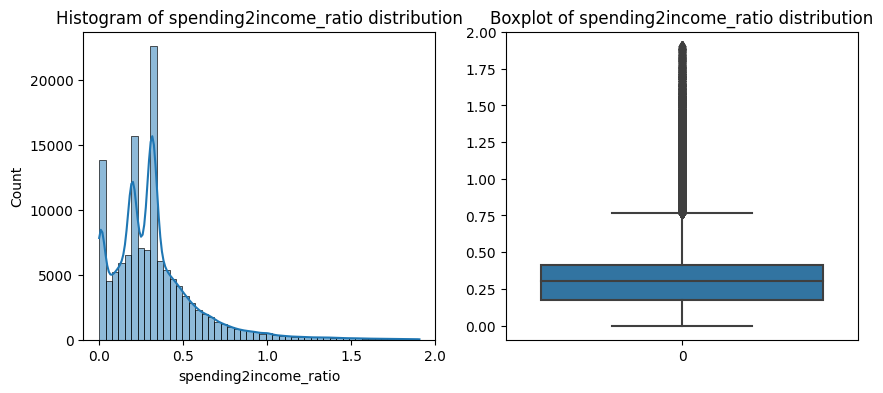

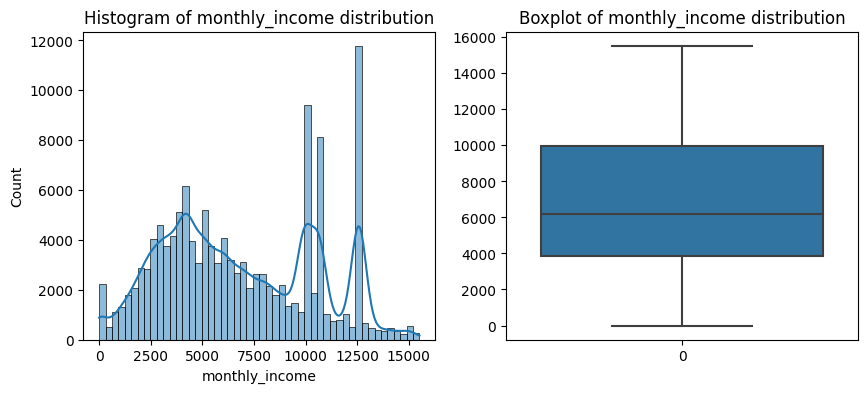

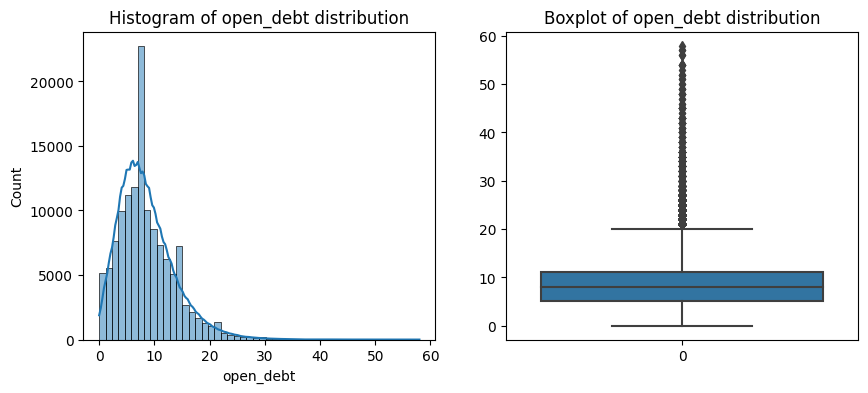

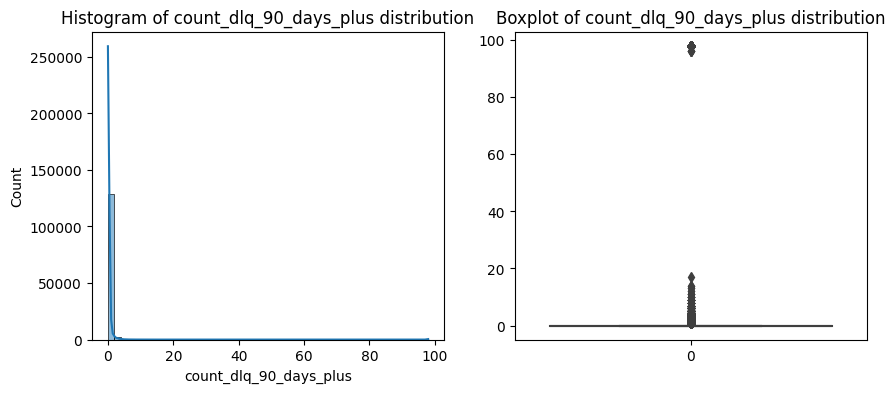

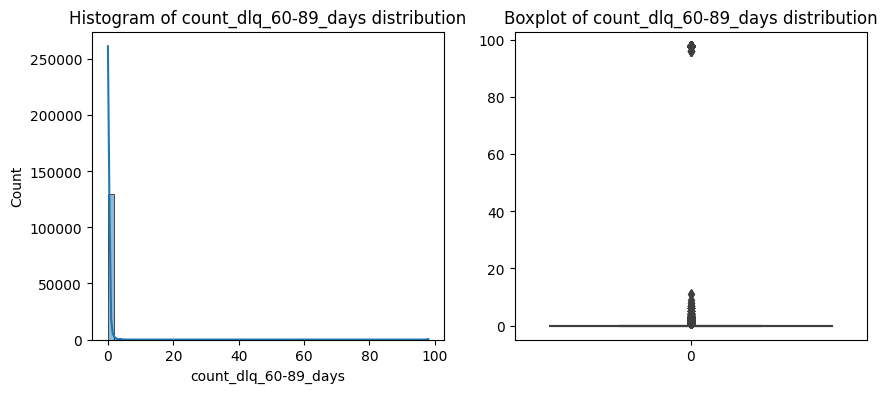

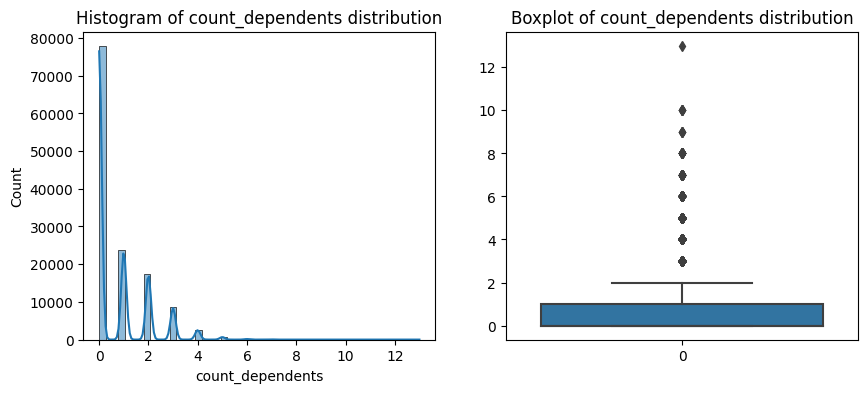

In [98]:
for i in df[numeric].columns:
  hist_and_box(df[i], i)

We can see some peak values which we've used for replacement of the omissions. Shouldn't be a problem for a model with regularization or gradient descent.

Now let's have look at histograms for categorical variables.

In [99]:
def just_hist(data, label):
  plt.title(f'Histogram of {label} distribution');
  sns.histplot(data, bins=50, alpha=0.5);
  plt.show();

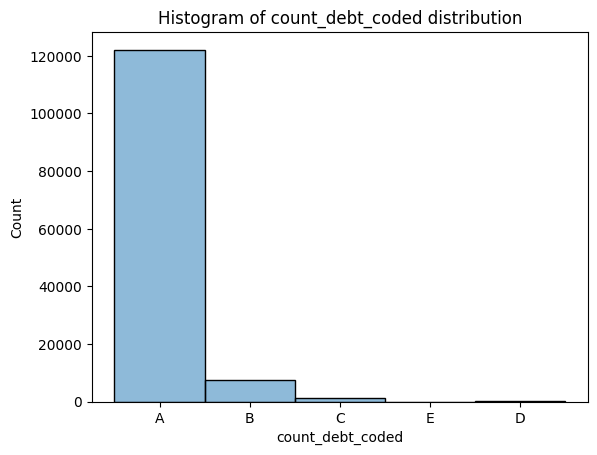

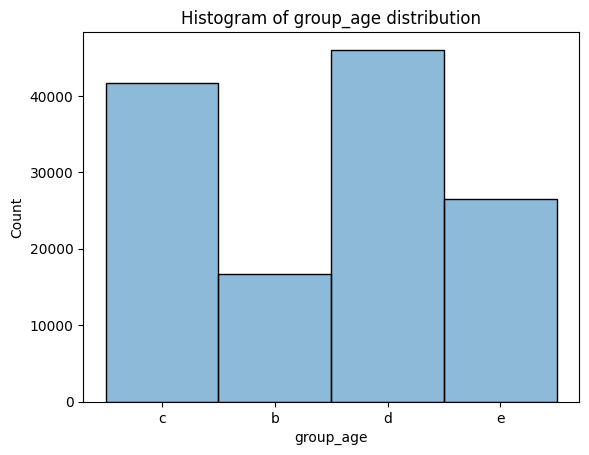

In [100]:
for i in df[categorical].columns:
  just_hist(df[i], i)

Since the 'group_age' variable duplicates the information from 'age', we don't need it other than in EDA. So now we can drop it.

In [101]:
df = df.drop(columns='group_age')

We can see that there's an incredibly small proportion of debt codes 'c', 'd' and 'e'. Let's have a look at the borderline number of debts they correspond with (using max).

In [102]:
df.groupby('count_debt_coded')['open_debt'].max()

count_debt_coded
A    57
B    49
C    54
D    36
E    58
Name: open_debt, dtype: int64

That variable can be not representative at all.

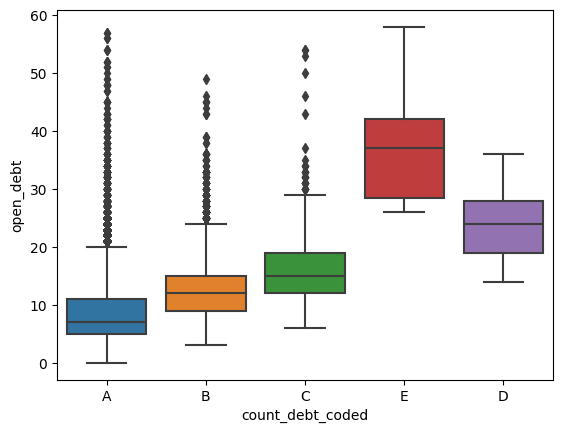

In [103]:
sns.boxplot(x='count_debt_coded', y='open_debt', data=df);

Both variables should represent the same (a number of open loans with some varying nuances), but as we can see, they correspond inconsistently.

Thus we can be pragmatic about the data and drop the `count_debt_coded` variable.

In [104]:
df = df.drop(columns=['count_debt_coded'])

### Comparing the classes

Let's compare total and monthly incomes for out classes.

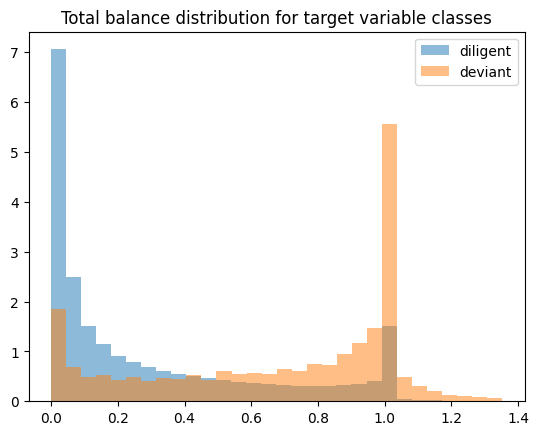

In [105]:
plt.hist(df.loc[df['dlq_90_days_plus'] == 0, 'balance2credit_ratio'],
density=True,
label='diligent',
bins=30,
alpha=0.5);

plt.hist(df.loc[df['dlq_90_days_plus'] == 1, 'balance2credit_ratio'],
density=True,
label='deviant',
bins=30,
alpha=0.5);

plt.title('Total balance distribution for target variable classes');
plt.legend();

The total balance of deviant customers is dramatically bigger. That might be one of our main predictors.

In [106]:
print(st.ttest_ind(df.loc[df['dlq_90_days_plus'] == 0, 'balance2credit_ratio'],
             df.loc[df['dlq_90_days_plus'] == 1, 'balance2credit_ratio']))

print('Mean of total balance for diligent:',
      df.loc[df['dlq_90_days_plus'] == 0, 'balance2credit_ratio'].mean())

print('Mean of total balance for deviant:', df.loc[df['dlq_90_days_plus'] == 1,
                                                 'balance2credit_ratio'].mean())

Ttest_indResult(statistic=-104.2022175477076, pvalue=0.0)
Mean of total balance for diligent: 0.29337726394567876
Mean of total balance for deviant: 0.6825532250127154


We can reject the null hypothesis about equal mean values. Deviant customers statistically have more money on their balance.

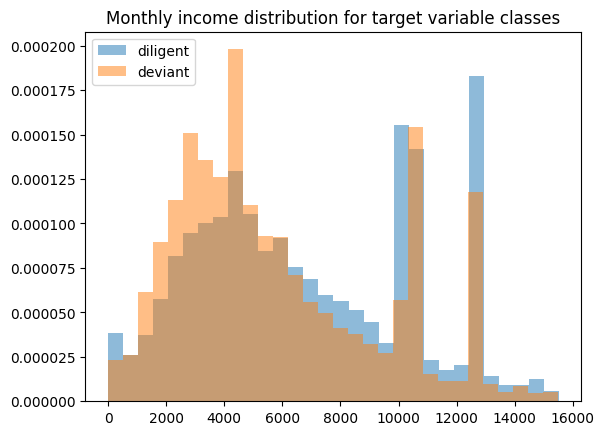

In [107]:
plt.hist(df.loc[df['dlq_90_days_plus'] == 0, 'monthly_income'],
density=True,
label='diligent',
bins=30,
alpha=0.5);

plt.hist(df.loc[df['dlq_90_days_plus'] == 1, 'monthly_income'],
density=True,
label='deviant',
bins=30,
alpha=0.5);

plt.title('Monthly income distribution for target variable classes');
plt.legend();

Monthly income also looks a bit bigger for diligent customers, via statistical hypothesis.

In [108]:
print(st.ttest_ind(df.loc[df['dlq_90_days_plus'] == 0, 'monthly_income'],
             df.loc[df['dlq_90_days_plus'] == 1, 'monthly_income']))

print('Mean of monthly income for diligent:',
      df.loc[df['dlq_90_days_plus'] == 0, 'monthly_income'].mean())

print('Mean of monthly income for deviant:', df.loc[df['dlq_90_days_plus'] == 1,
                                                 'monthly_income'].mean())

Ttest_indResult(statistic=24.162520688957716, pvalue=1.0575632430704581e-128)
Mean of monthly income for diligent: 6878.767877746861
Mean of monthly income for deviant: 5889.24047167591


We can reject the null hypothesis about equal mean values. Deviant customers statistically have less monthly income.

For example, let's compare the spending ratio distribution between the classes.

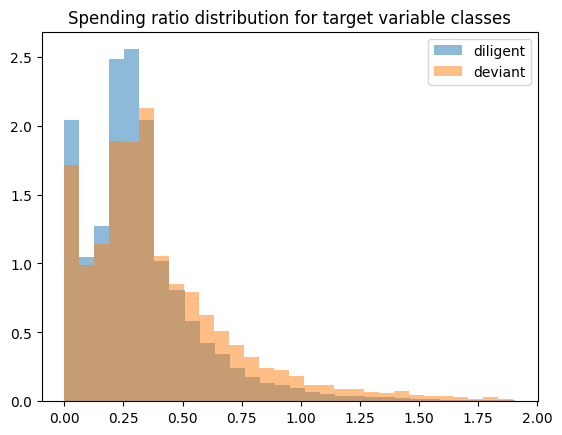

In [109]:
plt.hist(df.loc[df['dlq_90_days_plus'] == 0, 'spending2income_ratio'],
density=True,
label='diligent',
bins=30,
alpha=0.5);

plt.hist(df.loc[df['dlq_90_days_plus'] == 1, 'spending2income_ratio'],
density=True,
label='deviant',
bins=30,
alpha=0.5);

plt.title('Spending ratio distribution for target variable classes');
plt.legend();

Spending ratio looks pretty much the same.

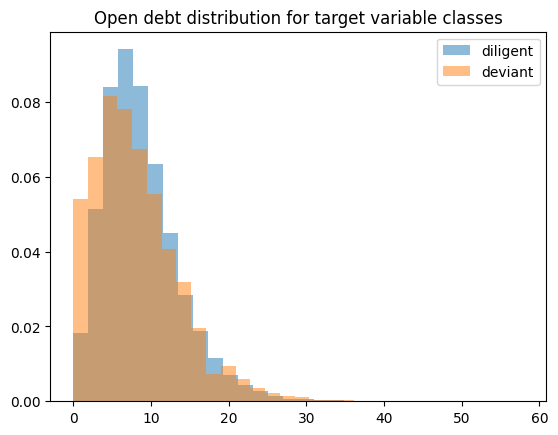

In [110]:
plt.hist(df.loc[df['dlq_90_days_plus'] == 0, 'open_debt'],
density=True,
label='diligent',
bins=30,
alpha=0.5);

plt.hist(df.loc[df['dlq_90_days_plus'] == 1, 'open_debt'],
density=True,
label='deviant',
bins=30,
alpha=0.5);

plt.title('Open debt distribution for target variable classes');
plt.legend();

So does the number of opened credit products, surprisingly.

Maybe the age shall differ.

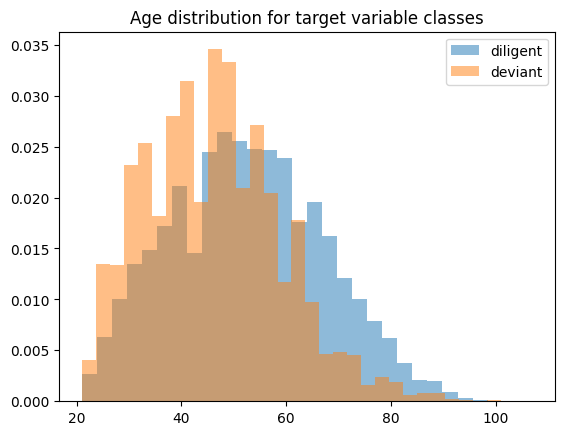

In [111]:
plt.hist(df.loc[df['dlq_90_days_plus'] == 0, 'age'],
density=True,
label='diligent',
bins=30,
alpha=0.5);

plt.hist(df.loc[df['dlq_90_days_plus'] == 1, 'age'],
density=True,
label='deviant',
bins=30,
alpha=0.5);

plt.title('Age distribution for target variable classes');
plt.legend();


Deviant customers might tend to be slightly younger.

In [112]:
print(st.ttest_ind(df.loc[df['dlq_90_days_plus'] == 0, 'age'],
             df.loc[df['dlq_90_days_plus'] == 1, 'age']))

print('Mean of age for diligent:',
      df.loc[df['dlq_90_days_plus'] == 0, 'age'].mean())

print('Mean of age for deviant:', df.loc[df['dlq_90_days_plus'] == 1,
                                                 'age'].mean())

Ttest_indResult(statistic=41.15427545127384, pvalue=0.0)
Mean of age for diligent: 52.571055923984595
Mean of age for deviant: 45.92890995260664


We can reject the null hypothesis about equal mean values. Deviant customers indeed are statistically younger.

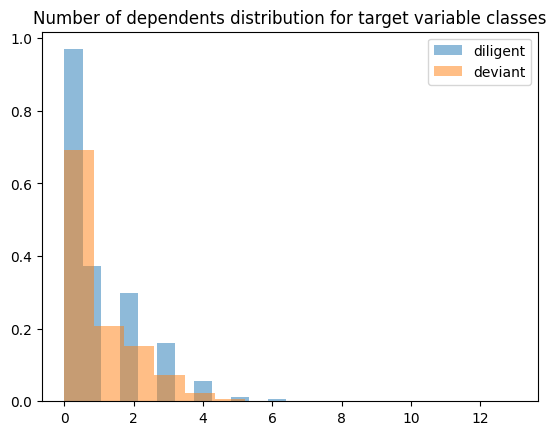

In [113]:
plt.hist(df.loc[df['dlq_90_days_plus'] == 1, 'count_dependents'],
density=True,
label='diligent',
bins=15,
alpha=0.5);

plt.hist(df.loc[df['dlq_90_days_plus'] == 0, 'count_dependents'],
density=True,
label='deviant',
bins=15,
alpha=0.5);

plt.title('Number of dependents distribution for target variable classes');
plt.legend();

Distribution of dependents' quantity looks pretty much the same.

We can also have a look at our variables counting the delinquencies.

In [114]:
diligent_values = df.loc[df['dlq_90_days_plus'] == 0,'count_dlq_30-59_days']\
.value_counts().rename('diligent').round(3)
deviant_values = df.loc[df['dlq_90_days_plus'] == 1,'count_dlq_30-59_days']\
.value_counts().rename('deviant').round(3)

display(pd.concat([deviant_values, diligent_values], axis=1).sort_index())

diligent_values = df.loc[df['dlq_90_days_plus'] == 0,'count_dlq_30-59_days']\
.value_counts(normalize=True).rename('diligent').round(3)
deviant_values = df.loc[df['dlq_90_days_plus'] == 1,'count_dlq_30-59_days']\
.value_counts(normalize=True).rename('deviant').round(3)

display(pd.concat([deviant_values, diligent_values], axis=1).sort_index())

,deviant,diligent
0,4380,105596.0
1,2053,11981.0
2,1035,2953.0
3,535,1015.0
4,284,379.0
5,134,170.0
6,67,57.0
7,26,25.0
8,8,16.0
9,4,6.0


,deviant,diligent
0,0.506,0.863
1,0.237,0.098
2,0.120,0.024
3,0.062,0.008
4,0.033,0.003
5,0.015,0.001
6,0.008,0.000
7,0.003,0.000
8,0.001,0.000
9,0.000,0.000


So the deviant tend to have more deliqencies in a 30-59 day span. Mostly the number of delinquencies in that span is less than 4.

Also we can notice very strange data in 13+ delinquencies which counter-intuitively is basically the same for diligent and deviant.

In [115]:
diligent_values = df.loc[df['dlq_90_days_plus'] == 0,'count_dlq_60-89_days']\
.value_counts().rename('diligent').round(3)
deviant_values = df.loc[df['dlq_90_days_plus'] == 1,'count_dlq_60-89_days']\
.value_counts().rename('deviant').round(3)

display(pd.concat([deviant_values, diligent_values], axis=1).sort_index())

diligent_values = df.loc[df['dlq_90_days_plus'] == 0,'count_dlq_60-89_days']\
.value_counts(normalize=True).rename('diligent').round(3)
deviant_values = df.loc[df['dlq_90_days_plus'] == 1,'count_dlq_60-89_days']\
.value_counts(normalize=True).rename('deviant').round(3)

display(pd.concat([deviant_values, diligent_values], axis=1).sort_index())

,deviant,diligent
0,6321.0,118102.0
1,1505.0,3452.0
2,476.0,469.0
3,149.0,122.0
4,51.0,36.0
5,16.0,12.0
6,9.0,3.0
7,3.0,2.0
8,1.0,1.0
9,NaN,1.0


,deviant,diligent
0,0.731,0.966
1,0.174,0.028
2,0.055,0.004
3,0.017,0.001
4,0.006,0.000
5,0.002,0.000
6,0.001,0.000
7,0.000,0.000
8,0.000,0.000
9,NaN,0.000


The 60-89 day span confirms the findings. We can also notice the strange 11+ delinquencies data here.

In [116]:
diligent_values = df.loc[df['dlq_90_days_plus'] == 0,'count_dlq_90_days_plus']\
.value_counts().rename('diligent').round(3)
deviant_values = df.loc[df['dlq_90_days_plus'] == 1,'count_dlq_90_days_plus']\
.value_counts().rename('deviant').round(3)

display(pd.concat([deviant_values, diligent_values], axis=1).sort_index())

diligent_values = df.loc[df['dlq_90_days_plus'] == 0,'count_dlq_90_days_plus']\
.value_counts(normalize=True).rename('diligent').round(3)
deviant_values = df.loc[df['dlq_90_days_plus'] == 1,'count_dlq_90_days_plus']\
.value_counts(normalize=True).rename('deviant').round(3)

display(pd.concat([deviant_values, diligent_values], axis=1).sort_index())

,deviant,diligent
0,5735,118061.0
1,1519,3074.0
2,642,659.0
3,319,237.0
4,155,82.0
5,64,41.0
6,40,26.0
7,22,5.0
8,12,4.0
9,13,4.0


,deviant,diligent
0,0.663,0.965
1,0.176,0.025
2,0.074,0.005
3,0.037,0.002
4,0.018,0.001
5,0.007,0.000
6,0.005,0.000
7,0.003,0.000
8,0.001,0.000
9,0.002,0.000


And so confirms the 90+ day span. The finding can be summarized to "*deviant tend to have more delinquencies than diligent*" if we delete the strange descrepancy.

Yeah, "*duh*". I understand.

In [117]:
df = df.loc[df['dlq_90_days_plus'] <= 11]

In [118]:
df.head(1)

,dlq_90_days_plus,balance2credit_ratio,age,count_dlq_30-59_days,spending2income_ratio,monthly_income,open_debt,count_dlq_90_days_plus,count_dlq_60-89_days,count_dependents
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0


In [119]:
from google.colab import files

df.to_csv('preprocessed_data.csv', index=False)
files.download('preprocessed_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's head to the machine learning part, where our sophisticated models will be able to find more complex relations between variables.

## Machine learning

### Engineering features

In [120]:
features = df.drop(columns='dlq_90_days_plus')
target = df['dlq_90_days_plus']

In [121]:
features.head()

,balance2credit_ratio,age,count_dlq_30-59_days,spending2income_ratio,monthly_income,open_debt,count_dlq_90_days_plus,count_dlq_60-89_days,count_dependents
0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0
1,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0
2,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0
3,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0
4,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0


In [122]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            shuffle=True,
                                                                            random_state=RANDOM_STATE)

We can start with a simple logistic regression to test how the metrics behave with or without scaling the data or dealing with imbalance.

In [123]:
lr_model = LogisticRegression()
lr_model.fit(features_train, target_train)
print(classification_report(target_train, lr_model.predict(features_train)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.94      0.99      0.97     91776
           1       0.56      0.10      0.17      6430

    accuracy                           0.94     98206
   macro avg       0.75      0.55      0.57     98206
weighted avg       0.92      0.94      0.91     98206



A heavy imbalance takes its toll on our f1-score. Let's try to upsample the data.

In [124]:
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
features_train_smote, target_train_smote = smote.fit_resample(features_train, target_train)

In [125]:
lr_model.fit(features_train_smote, target_train_smote)
print(classification_report(target_train, lr_model.predict(features_train)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.98      0.72      0.83     91776
           1       0.16      0.75      0.26      6430

    accuracy                           0.72     98206
   macro avg       0.57      0.73      0.54     98206
weighted avg       0.92      0.72      0.79     98206



An F1-score got a bit up, but still not perfect. We can also try undersampling the data.

In [126]:
undersample = RandomUnderSampler()
features_train_undersampled, target_train_undersampled = undersample.fit_resample(features_train, target_train)

In [127]:
lr_model.fit(features_train_undersampled, target_train_undersampled)
print(classification_report(target_train, lr_model.predict(features_train)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.98      0.75      0.85     91776
           1       0.17      0.74      0.28      6430

    accuracy                           0.75     98206
   macro avg       0.58      0.75      0.57     98206
weighted avg       0.92      0.75      0.81     98206



Currently the undersampled data works better. Let's apply scaling before using LightGBM.

In [128]:
scaler = StandardScaler()
features_train_values = scaler.fit_transform(features_train)
features_test_values = scaler.transform(features_test)

features_train = pd.DataFrame(features_train_values, columns=features_train.columns)
features_test = pd.DataFrame(features_test_values, columns=features_test.columns)

### Training  LightGBM model

We shall use RandomizedSearchCV to rapidly find optimal hyperparameteres for out LGBMClassifier.

Considering our heavy imbalance, we could use a PR AUC metric (which tends to focus on a positive class), but we've decided to go with an undersampled data, so we  care equally about negative and positive classes, and thus use ROC-AUC.

In [129]:
param_grid = {'num_leaves': np.arange(2, 50, 2),
              'reg_lambda' : np.arange(1, 20, 2),
              'max_depth' : np.arange(2, 100, 2),
              'learning_rate' : np.arange(0.1, 1, 0.05)}

In [130]:
lgb = LGBMClassifier(random_state=RANDOM_STATE)

best_lgb = RandomizedSearchCV(lgb,
                              param_distributions=param_grid,
                              n_iter=50,
                              cv=3,
                              scoring='roc_auc',
                              verbose=2)

best_lgb.fit(features_train_undersampled, target_train_undersampled)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END learning_rate=0.5500000000000002, max_depth=88, num_leaves=36, reg_lambda=5; total time=   1.9s
[CV] END learning_rate=0.5500000000000002, max_depth=88, num_leaves=36, reg_lambda=5; total time=   0.2s
[CV] END learning_rate=0.5500000000000002, max_depth=88, num_leaves=36, reg_lambda=5; total time=   0.2s
[CV] END learning_rate=0.6500000000000001, max_depth=72, num_leaves=48, reg_lambda=17; total time=   0.2s
[CV] END learning_rate=0.6500000000000001, max_depth=72, num_leaves=48, reg_lambda=17; total time=   0.3s
[CV] END learning_rate=0.6500000000000001, max_depth=72, num_leaves=48, reg_lambda=17; total time=   0.2s
[CV] END learning_rate=0.5500000000000002, max_depth=68, num_leaves=6, reg_lambda=17; total time=   0.1s
[CV] END learning_rate=0.5500000000000002, max_depth=68, num_leaves=6, reg_lambda=17; total time=   0.1s
[CV] END learning_rate=0.5500000000000002, max_depth=68, num_leaves=6, reg_lambda=17; total tim

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=11235),
                   n_iter=50,
                   param_distributions={'learning_rate': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68,
       70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]),
                                        'num_leaves': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48]),
                                        'reg_lambda': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])},
                   scoring='roc_auc', verbose=2)

In [131]:
print(f"The best LGBM model's hyperparameters are {best_lgb.best_params_}, \n\
its ROC-AUC is {best_lgb.best_score_:.3f}" )

The best LGBM model's hyperparameters are {'reg_lambda': 7, 'num_leaves': 4, 'max_depth': 54, 'learning_rate': 0.15000000000000002}, 
its ROC-AUC is 0.859


Let's check other metrics for the model.

In [132]:
print(classification_report(target_train, best_lgb.predict(features_train)))

              precision    recall  f1-score   support

           0       0.98      0.76      0.85     91776
           1       0.18      0.77      0.29      6430

    accuracy                           0.76     98206
   macro avg       0.58      0.76      0.57     98206
weighted avg       0.93      0.76      0.82     98206



Way better than a logistic regression. The fitting with cross-validation took us 30 seconds, so the model can be considered optimal.

### Testing the model

Now let's check the model's quality on the test data.

In [139]:
print(f'ROC-AUC score for the LGBM model is: \n\
{roc_auc_score(target_test, best_lgb.predict(features_test)):.3f}')

print(f'Accuracy score for the LGBM model is: \n\
{accuracy_score(target_test, best_lgb.predict(features_test)):.3f}')

print('Classification report: \n\n',\
      classification_report(target_test, best_lgb.predict(features_test)))

ROC-AUC score for the LGBM model is: 
0.766
Accuracy score for the LGBM model is: 
0.755
Classification report: 

               precision    recall  f1-score   support

           0       0.98      0.75      0.85     30515
           1       0.19      0.78      0.30      2221

    accuracy                           0.76     32736
   macro avg       0.58      0.77      0.58     32736
weighted avg       0.93      0.76      0.81     32736



In [134]:
best_lgb.predict_proba(features_test)[:10, 1] > 0.2

array([ True, False,  True,  True,  True,  True, False,  True, False,
        True])

Now we compare our model with a dummy model predicting the majority (0) each time.

In [135]:
dummy_predictions = pd.Series(data=np.zeros(target_test.shape[0]))

In [138]:
print(f'ROC-AUC score for the dummy model is: \n\
{roc_auc_score(target_test, dummy_predictions):.3f}')

print(f'Accuracy score for the dummy model is: \n\
{accuracy_score(target_test, dummy_predictions):.3f}')

print('Classification report: \n\n',\
      classification_report(target_test, dummy_predictions))

ROC-AUC score for the dummy model is: 
0.500
Accuracy score for the dummy model is: 
0.932
Classification report: 

               precision    recall  f1-score   support

           0       0.93      1.00      0.96     30515
           1       0.00      0.00      0.00      2221

    accuracy                           0.93     32736
   macro avg       0.47      0.50      0.48     32736
weighted avg       0.87      0.93      0.90     32736



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


So our LGBM model has beaten the dummy model in predicting the positive class (1) which is not suprising. Let's save it.

In [137]:
pickle.dump(best_lgb, open('best_lgb.pkl', 'wb'))

## Conclusions

EDA:

* Deviant customers statistically have more money on their balance;
* And even considering that, deviant customers have less monthly income than diligent ones;
* Deviant customers are statistically younger.

ML:

* We've maximized our metrics on train using OHE, standard scaling of the data and downsampling the majority class (0).
* The best LGBM model's hyperparameters are {'reg_lambda': 7, 'num_leaves': 4, 'max_depth': 54, 'learning_rate': 0.15}.
* The best model's ROC-AUC on a test data is 0.766 and its accuracy is 0.755.

Thank you for being with us on this little experiment!